# `pycut` demo 

This notebook demonstrates `pyutils.pycut` module functionality for analysis cuts, including:

- Cut definition and management
- Cut flow generation and display
- Cut configuration comparison
- State management

>Note: Not shown here is the combination of cut flows when applying cuts during multiprocessing. 

## 1. Setup and Imports

In [1]:
import awkward as ak
import numpy as np
from pyutils.pyprocess import Processor 
from pyutils.pylogger import Logger
from pyutils.pyvector import Vector
from pyutils.pyselect import Select
from pyutils.pycut import CutManager
from pyutils.pyplot import Plot

In [2]:
# Initialise utilities
verbosity = 2

logger = Logger(
    verbosity=verbosity,
    print_prefix="[pycut_demo]"
)

selector = Select(verbosity=1)
vector = Vector(verbosity=1)

[pyvector] ⭐️ Initialised Vector with verbosity = 1


## 2. Data Processing

Load data using the pyprocess module with relevant branches for analysis.

In [3]:
processor = Processor(verbosity=1)

# Define file list path and branches
file_list_path = "/exp/mu2e/data/users/sgrant/pyutils-test/filelists/local_file_list.txt"
branches = {
    "evt" : ["event"],
    "trk" : ["trk.nactive", "trk.pdg", "trkqual.result"],
    "trkfit" : ["trksegs"]
}

# Process the files
data = processor.process_data(
    file_list_path=file_list_path,
    branches=branches
)

[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = False
	verbosity=1
[pyprocess] ⭐️ Loading file list from /exp/mu2e/data/users/sgrant/pyutils-test/filelists/local_file_list.txt
[pyprocess] ✅ Successfully loaded file list
	Path: None
	Count: 10 files
[pyprocess] ⭐️ Starting processing on 10 files with 10 threads


Processing: 100%|██████████████████████████████| 10/10 [00:05<00:00,  1.87file/s, successful=10, failed=0]

[pyprocess] ✅ Returning concatenated array containing 70255 events


## 3. Cut manager initialisation

In [4]:
cut_manager = CutManager(verbosity=verbosity)

[pycut] ✅ Initialised


## 4. Cut definitions

Define realistic Mu2e analysis cuts organised into logical groups:
- **Preselect**: Basic track reconstruction requirements
- **Reco**: Track quality and hit requirements
- **Meas**: Physics measurement cuts (timing and momentum)

> **Note**: Within `EventNtuple` all cuts must be defined on the same level of nesting, such as track-level.

### 4.1 Preselection cuts

In [5]:
logger.log("Defining preselection cuts...", "info")

# Tracker entrance segments
at_trk_front = selector.select_surface(data["trkfit"], surface_name="TT_Front") 
has_trk_front = ak.any(at_trk_front, axis=-1)

cut_manager.add_cut(
    name="has_trk_front",
    description="Segments at tracker entrance",
    mask=has_trk_front,
    active=True,
    group="Preselect"
)

# Electron track fits
is_reco_electron = selector.is_electron(data["trk"])
cut_manager.add_cut(
    name="is_reco_electron",
    description="Electron track fits",
    mask=is_reco_electron,
    active=True,
    group="Preselect"
)

# Downstream track requirement
is_downstream = selector.is_downstream(data["trkfit"]) 
is_downstream_track = ak.all(~at_trk_front | is_downstream, axis=-1) 
cut_manager.add_cut(
    name="is_downstream",
    description=r"Downstream tracks ($p_{z} > 0$)",
    mask=is_downstream_track,
    active=True,
    group="Preselect"
)

[pycut_demo] ⭐️ Defining preselection cuts...
[pyselect] ✅ Returning mask for trksegs with sid = 0
[pycut] ⭐️ Added cut has_trk_front with index 0 in group 'Preselect'
[pyselect] ✅ Returning mask for e- tracks
[pycut] ⭐️ Added cut is_reco_electron with index 1 in group 'Preselect'
[pyselect] ✅ Returning mask for downstream track segments (p_z > 0)
[pycut] ⭐️ Added cut is_downstream with index 2 in group 'Preselect'


### 4.2 Reconstruction cuts

In [6]:
logger.log("Defining reconstruction cuts...", "info")

# Track quality requirement
good_trkqual = selector.select_trkqual(data["trk"], 0.2)
cut_manager.add_cut(
    name="good_trkqual",
    description="Track quality > 0.2",
    mask=good_trkqual,
    active=True,
    group="Reco"
)

# Sufficient hits requirement
has_hits = selector.has_n_hits(data["trk"], 20)
cut_manager.add_cut(
    name="has_hits",
    description="Active hits >= 20", 
    mask=has_hits,
    active=True,
    group="Reco"
)

[pycut_demo] ⭐️ Defining reconstruction cuts...
[pyselect] ✅ Returning mask for trkqual > 0.2
[pycut] ⭐️ Added cut good_trkqual with index 3 in group 'Reco'
[pyselect] ✅ Returning mask for nactive > 20
[pycut] ⭐️ Added cut has_hits with index 4 in group 'Reco'


### 4.3 Measurement cuts

In [7]:
logger.log("Defining measurement cuts...", "info")

# Timing window (t0)
within_t0 = ((640 < data["trkfit"]["trksegs"]["time"]) & 
            (data["trkfit"]["trksegs"]["time"] < 1650))
within_t0_track = ak.all(~at_trk_front | within_t0, axis=-1) 
cut_manager.add_cut(
    name="within_t0",
    description="t0 window (640 < t0 < 1650 ns)",
    mask=within_t0_track, 
    active=True,
    group="Meas"
)

# Momentum signal window
mom = vector.get_mag(data["trkfit"]["trksegs"], "mom") 
within_sig_win = ((mom > 103.6) & (mom < 104.9))
within_sig_win_track = ak.all(~at_trk_front | within_sig_win, axis=-1)
cut_manager.add_cut(
    name="within_sig_win",
    description="Signal window (103.6 < p < 104.9 MeV/c)", 
    mask=within_sig_win_track,
    active=True,
    group="Meas"
)

[pycut_demo] ⭐️ Defining measurement cuts...
[pycut] ⭐️ Added cut within_t0 with index 5 in group 'Meas'
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pycut] ⭐️ Added cut within_sig_win with index 6 in group 'Meas'


## 5. Nominal cut flow

Generate and display the nominal (full analysis) cut flow.

In [8]:
# Generate and display cut flow
nominal_cut_flow = cut_manager.create_cut_flow(data)
nominal_df = cut_manager.format_cut_flow(nominal_cut_flow)

logger.log("Nominal cut flow:", "info")
display(nominal_df)

# Save nominal state
cut_manager.save_state("nominal_cuts")

[pycut_demo] ⭐️ Nominal cut flow:


,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,N/A,70255,100.00,100.00,No selection applied
1,has_trk_front,Preselect,70002,99.64,99.64,Segments at tracker entrance
2,is_reco_electron,Preselect,64069,91.19,91.52,Electron track fits
3,is_downstream,Preselect,39788,56.63,62.10,Downstream tracks ($p_{z} > 0$)
4,good_trkqual,Reco,18229,25.95,45.82,Track quality > 0.2
5,has_hits,Reco,18149,25.83,99.56,Active hits >= 20
6,within_t0,Meas,177,0.25,0.98,t0 window (640 < t0 < 1650 ns)
7,within_sig_win,Meas,1,0.00,0.56,Signal window (103.6 < p < 104.9 MeV/c)


[pycut] ⭐️ Saved current cut states as 'nominal_cuts'


## 6. Loose cut flow

Create a loose cuts configuration by removing the measurement requirements while keeping reconstruction quality cuts.

In [9]:
logger.log("Creating loose cuts configuration...", "info")

# Remove timing and momentum windows for loose selection
cut_manager.toggle_cut({
    "within_t0": False,      # Remove t0 window
    "within_sig_win": False  # Remove momentum window
})

# Generate loose cut flow
loose_cut_flow = cut_manager.create_cut_flow(data)
loose_df = cut_manager.format_cut_flow(loose_cut_flow)

logger.log("Loose cuts flow:", "info")
display(loose_df)

# Save loose cuts state
cut_manager.save_state("loose_cuts")

[pycut_demo] ⭐️ Creating loose cuts configuration...
[pycut] ⭐️ Successfully deactivated cut(s): ['within_t0', 'within_sig_win']
[pycut_demo] ⭐️ Loose cuts flow:


,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,N/A,70255,100.00,100.00,No selection applied
1,has_trk_front,Preselect,70002,99.64,99.64,Segments at tracker entrance
2,is_reco_electron,Preselect,64069,91.19,91.52,Electron track fits
3,is_downstream,Preselect,39788,56.63,62.10,Downstream tracks ($p_{z} > 0$)
4,good_trkqual,Reco,18229,25.95,45.82,Track quality > 0.2
5,has_hits,Reco,18149,25.83,99.56,Active hits >= 20


[pycut] ⭐️ Saved current cut states as 'loose_cuts'


## 7. Preselection-only cut flow

Create a very loose configuration with only basic preselection cuts active.

In [10]:
logger.log("Creating preselection-only configuration...", "info")

# Restore to nominal cuts first
cut_manager.restore_state("nominal_cuts")

# Deactivate reconstruction and measurement cuts
cut_manager.toggle_group({
    "Reco": False,     # Deactivate reconstruction cuts
    "Meas": False      # Deactivate measurement cuts
})

# Generate preselection-only cut flow
presel_cut_flow = cut_manager.create_cut_flow(data)
presel_df = cut_manager.format_cut_flow(presel_cut_flow)

logger.log("Preselection-only cut flow:", "info")
display(presel_df)

# Save preselection cuts state
cut_manager.save_state("preselection_cuts")

[pycut_demo] ⭐️ Creating preselection-only configuration...
[pycut] ✅ Restored 7 cuts from state 'nominal_cuts'
[pycut] ⭐️ Successfully deactivated group(s): ['Reco (2 cuts)', 'Meas (2 cuts)']
[pycut_demo] ⭐️ Preselection-only cut flow:


,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,N/A,70255,100.00,100.00,No selection applied
1,has_trk_front,Preselect,70002,99.64,99.64,Segments at tracker entrance
2,is_reco_electron,Preselect,64069,91.19,91.52,Electron track fits
3,is_downstream,Preselect,39788,56.63,62.10,Downstream tracks ($p_{z} > 0$)


[pycut] ⭐️ Saved current cut states as 'preselection_cuts'


## 8. Cut flow comparison

Apply different cut configurations and create momentum distributions for comparison.

In [11]:
# Reinitialise selector and vector with low verbosity for cleaner output
vector = Vector(verbosity=0)
selector = Select(verbosity=0)

logger.log("Applying cuts and extracting momentum distributions...", "info")

# Define cut configurations to compare
cut_configs = {
   "Preselection": "preselection_cuts",
   "Loose cuts": "loose_cuts",
   "Nominal cuts": "nominal_cuts"
}

mom_cut = {}

for config_name, state_name in cut_configs.items():
    # Restore cut state
    cut_manager.restore_state(state_name)
    
    # Get the combined cut mask
    trk_mask = cut_manager.combine_cuts(active_only=True)
    
    # Apply mask to tracks and track segments 
    filtered_data = ak.copy(data)
    filtered_data["trk"] = filtered_data["trk"][trk_mask]
    filtered_data["trkfit"] = filtered_data["trkfit"][trk_mask]
    
    # Clean up events with no tracks after cuts 
    evt_mask = ak.any(trk_mask, axis=-1)
    filtered_data = filtered_data[evt_mask]
    
    # Get momentum for selected events
    mom_mag = vector.get_mag(filtered_data["trkfit"]["trksegs"], "mom")
    at_trk_front = selector.select_surface(filtered_data["trkfit"], surface_name="TT_Front")
    mom_at_trk_front = mom_mag[at_trk_front]
    flat_mom_at_trk_front = ak.flatten(mom_at_trk_front)

    # Store momentum distribution
    mom_cut[config_name] = flat_mom_at_trk_front
       
    logger.log(f"{config_name}: {len(flat_mom_at_trk_front)} track segments", "info")

[pycut_demo] ⭐️ Applying cuts and extracting momentum distributions...
[pycut] ✅ Restored 7 cuts from state 'preselection_cuts'
[pycut_demo] ⭐️ Preselection: 45977 track segments
[pycut] ✅ Restored 7 cuts from state 'loose_cuts'
[pycut_demo] ⭐️ Loose cuts: 18392 track segments
[pycut] ✅ Restored 7 cuts from state 'nominal_cuts'
[pycut_demo] ⭐️ Nominal cuts: 1 track segments


## 9. Visualisation

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1
[pyplot] ✅ Wrote:
	momentum_cut_comparison.png


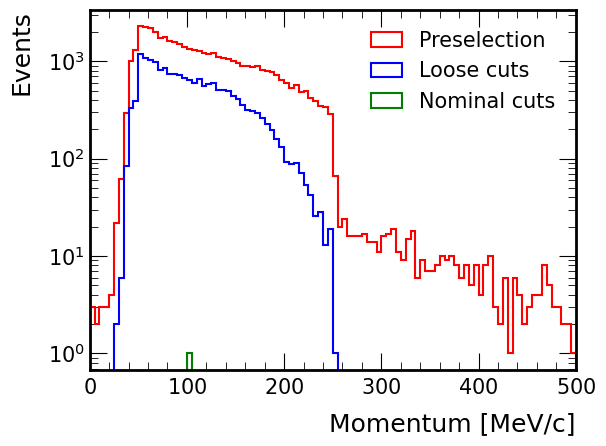

In [12]:
plotter = Plot(verbosity=1)

plotter.plot_1D_overlay(
    mom_cut,
    nbins=100, 
    xmin=0,
    xmax=500,
    log_y=True,
    xlabel="Momentum [MeV/c]",
    ylabel="Events",
    out_path="momentum_cut_comparison.png"
)

## 10. Write cut flow to file

Cut flows are formatted as `pandas` DataFrames, making them easy to save for documentation or further analysis.

In [13]:
logger.log("Saving cut flow to file...", "info")

out_path = "nominal_cut_flow.csv"
nominal_df.to_csv(out_path, index=False)
logger.log(f"Wrote {out_path}", "success")

[pycut_demo] ⭐️ Saving cut flow to file...
[pycut_demo] ✅ Wrote nominal_cut_flow.csv


## 11. State management summary

Demonstrate the state management capabilities of the cut manager.

In [14]:
logger.log("State management summary:", "info")

# List all saved states
saved_states = cut_manager.list_saved_states()
logger.log(f"Available saved states: {saved_states}", "info")

# Demonstrate restoration to original state
cut_manager.restore_original_state()
original_cut_flow = cut_manager.create_cut_flow(data)
original_df = cut_manager.format_cut_flow(original_cut_flow)

logger.log("Restored to original configuration:", "info")
display(original_df)

[pycut_demo] ⭐️ State management summary:
[pycut] ⭐️ Available saved states: ['nominal_cuts', 'loose_cuts', 'preselection_cuts']
[pycut_demo] ⭐️ Available saved states: ['nominal_cuts', 'loose_cuts', 'preselection_cuts']
[pycut] ✅ Restored 7 cuts to original states
[pycut_demo] ⭐️ Restored to original configuration:


,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,N/A,70255,100.00,100.00,No selection applied
1,has_trk_front,Preselect,70002,99.64,99.64,Segments at tracker entrance
2,is_reco_electron,Preselect,64069,91.19,91.52,Electron track fits
3,is_downstream,Preselect,39788,56.63,62.10,Downstream tracks ($p_{z} > 0$)
4,good_trkqual,Reco,18229,25.95,45.82,Track quality > 0.2
5,has_hits,Reco,18149,25.83,99.56,Active hits >= 20
6,within_t0,Meas,177,0.25,0.98,t0 window (640 < t0 < 1650 ns)
7,within_sig_win,Meas,1,0.00,0.56,Signal window (103.6 < p < 104.9 MeV/c)


## Summary

This notebook demonstrated the key features of the `pycut` module:

1. **Cut definition**: Organised cuts into logical groups (Preselect, Reco, Meas)
2. **Cut flow analysis**: Generated detailed cut flow tables showing event retention
3. **Configuration management**: Compared nominal, loose, and preselection-only configurations
4. **State management**: Saved and restored different cut configurations
5. **Event selection**: Applied cuts to data for physics analysis
6. **Visualisation**: Created momentum distribution comparisons
7. **Documentation**: Exported cut flows to CSV for records

The `pycut` module provides a flexible framework for managing complex analysis cut flows. 